In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/variant_types'

In [2]:
#dat_indir="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.01/numC100000_ispropFalse/"
#vars_type_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_variants/varsType.tsv"
# mult_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/vars_type/"
# sample_names="Control,Flt3l,Input"

#indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/variantTypes/"
# N_DONORS=2
#DONOR = 1

# indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute"
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/variantTypes"


indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/variantTypes/"

verbose=False

In [3]:
from os.path import join, exists, dirname
import os
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn

%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df

fig_utils from mplh
0.5.6


## Loop through donor af matrix

In [4]:
def get_high_variants(df, thresh, pct_thresh):
    """ Remove rows that have an average higher than threshold

    :param df:
    :param thresh:
    :return:
    """
    n_pct = pct_thresh*df.shape[0]
    #print('n_pct', n_pct)
    #print(df.head())
    return df.loc[:,((df>thresh).sum()>n_pct)].columns.values


# g = sns.clustermap(AF_df.loc[:, donor_vars])
# g.fig.savefig(fname=join(outdir, f"donor_variants.pdf"))
#plt.savefig(join(outdir, "donor_vars.png"))

In [5]:
cells_meta = pd.read_csv(join(dirname(indir.rstrip("/")), "cells_meta.tsv"), sep="\t")
#cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta["donor"] = cells_meta["donor"].astype('Int32')
cells_meta = cells_meta.dropna(subset=["donor"])
cells_meta

,index,ID,raw ID,new index,condition,donor,donor_index
0,0,AAACGAAAGGAGACTC-1_Flt3l,AAACGAAAGGAGACTC-1,1,Flt3l,1,1.0
1,1,AAACGAAAGTCACGCC-1_Flt3l,AAACGAAAGTCACGCC-1,2,Flt3l,1,2.0
2,2,AAACGAACAAGACTAA-1_Flt3l,AAACGAACAAGACTAA-1,3,Flt3l,1,3.0
3,3,AAACGAACAAGCGAAC-1_Flt3l,AAACGAACAAGCGAAC-1,4,Flt3l,0,1.0
4,4,AAACGAACACAGCCAC-1_Flt3l,AAACGAACACAGCCAC-1,5,Flt3l,0,2.0
...,...,...,...,...,...,...,...
13402,13402,TTTGTGTGTTTCTTAC-1_Input,TTTGTGTGTTTCTTAC-1,13403,Input,0,6999.0
13403,13403,TTTGTGTTCCTGAAAC-1_Input,TTTGTGTTCCTGAAAC-1,13404,Input,0,7000.0
13404,13404,TTTGTGTTCGGGAAAC-1_Input,TTTGTGTTCGGGAAAC-1,13405,Input,0,7001.0
13405,13405,TTTGTGTTCGGGACAA-1_Input,TTTGTGTTCGGGACAA-1,13406,Input,1,5691.0


In [6]:
all_af = []
all_dp = []
all_donor_vars = {}
all_vcf = []
for d, val in cells_meta.groupby("donor"):
    af_indir = join(indir, f"donor{d}")
    #cells_meta = pd.read_csv(join(af_indir, "cells_meta.tsv"), sep="\t")

    curr_af = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t").fillna(0)
    curr_af = curr_af.fillna(0)
    all_af.append(curr_af)
    all_dp.append(pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t").fillna(0))
    donor_vars = get_high_variants(curr_af, thresh=0.8, pct_thresh=0.8)
    all_donor_vars[d] = donor_vars
    print(f"number of donor vars: {len(donor_vars)}")
    all_vcf.append(pd.read_csv(join(af_indir, "cellSNP.base.vcf"),sep="\t"))
    all_vcf[-1]["donor"] = d
    all_vcf[-1] 
all_af = pd.concat(all_af, axis=0)
all_dp = pd.concat(all_dp, axis=0)

assert(not all_af.index.duplicated().any())
all_af

number of donor vars: 29
number of donor vars: 37


,4769G,11453A,14233G,709A,14905A,13188T,189G,15452A,10463C,1438G,...,3847C,10397G,3244A,10559G,11812G,4136G,15297C,5442C,15497A,4166G
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAACAAGCGAAC-1_Flt3l,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,1.0,...,1.000000,1.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
AAACGAACACAGCCAC-1_Flt3l,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,1.0,...,1.000000,1.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
AAACGAACACAGGTAG-1_Flt3l,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
AAACGAACATAGAATG-1_Flt3l,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,...,1.000000,0.75,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
AAACGAAGTATTCGAC-1_Flt3l,1.000000,0.0,0.000000,0.000000,0.000000,0.947368,0.0,0.0,0.0,1.0,...,1.000000,1.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTCAATGACTC-1_Input,1.000000,NaN,1.000000,1.000000,0.982143,0.000000,NaN,1.0,1.0,1.0,...,0.000000,0.00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
TTTGTGTCAGAAAGAG-1_Input,1.000000,NaN,0.993506,1.000000,1.000000,0.000000,NaN,1.0,1.0,1.0,...,0.000000,0.00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
TTTGTGTCATAGCCAT-1_Input,1.000000,NaN,1.000000,0.966667,1.000000,0.073171,NaN,1.0,1.0,1.0,...,0.030303,0.00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000


In [7]:
all_vcf_df = pd.concat(all_vcf).drop("index", axis=1)
all_vcf_df = all_vcf_df[~(all_vcf_df.duplicated())].reset_index(drop=True)
all_vcf_df

,#CHROM,POS,REF,ALT,donor
0,MT,4769,A4769,G,0
1,MT,11453,G11453,A,0
2,MT,14233,A14233,G,0
3,MT,709,G709,A,0
4,MT,14905,G14905,A,0
...,...,...,...,...,...
130,MT,3847,T3847,C,1
131,MT,10397,A10397,G,1
132,MT,3244,G3244,A,1
133,MT,10559,A10559,G,1


In [8]:
all_vcf_df["REF"] = all_vcf_df.apply(lambda x: x["REF"][0], axis=1)
all_vcf_df['ID'] = all_vcf_df.fillna("N").apply(lambda x: str(x["POS"]) + x['REF']+">"+x['ALT'], axis=1)
#all_vcf_df = all_vcf_df.set_index("ID")

In [9]:
variant_df = vu.type_of_variants(set(all_vcf_df["ID"].values))
variant_df["ID"] = variant_df.apply(lambda x: f'{x["position"]}{x["alt"]}', axis=1)
variant_df


,position,ref,alt,variant type,variant change,ID
14674T>C,14674,T,C,Transition,T>C,14674C
10463T>C,10463,T,C,Transition,T>C,10463C
11812A>G,11812,A,G,Transition,A>G,11812G
8461C>T,8461,C,T,Transition,C>T,8461T
16126T>C,16126,T,C,Transition,T>C,16126C
...,...,...,...,...,...,...
8697G>A,8697,G,A,Transition,G>A,8697A
5442T>C,5442,T,C,Transition,T>C,5442C
16304T>C,16304,T,C,Transition,T>C,16304C
16519T>C,16519,T,C,Transition,T>C,16519C


In [10]:
all_vcf_df["variant type"] = all_vcf_df.apply(lambda x: variant_df.loc[x['ID'], "variant type"], axis=1)
all_vcf_df["variant"] = all_vcf_df.apply(lambda x: variant_df.loc[x['ID'], "ID"], axis=1)
all_vcf_df

,#CHROM,POS,REF,ALT,donor,ID,variant type,variant
0,MT,4769,A,G,0,4769A>G,Transition,4769G
1,MT,11453,G,A,0,11453G>A,Transition,11453A
2,MT,14233,A,G,0,14233A>G,Transition,14233G
3,MT,709,G,A,0,709G>A,Transition,709A
4,MT,14905,G,A,0,14905G>A,Transition,14905A
...,...,...,...,...,...,...,...,...
130,MT,3847,T,C,1,3847T>C,Transition,3847C
131,MT,10397,A,G,1,10397A>G,Transition,10397G
132,MT,3244,G,A,1,3244G>A,Transition,3244A
133,MT,10559,A,G,1,10559A>G,Transition,10559G


In [11]:
all_vcf_df['is_donor_var'] = all_vcf_df.apply(lambda x: x["variant"] in all_donor_vars[x["donor"]], axis=1)
donor_spec_vcf_df = all_vcf_df[all_vcf_df['is_donor_var']].copy()


In [12]:
variant_df = variant_df.set_index("ID")

## A. Countplot of donor variants variant types 

In [13]:
donor_spec_vcf_df

,#CHROM,POS,REF,ALT,donor,ID,variant type,variant,is_donor_var
0,MT,4769,A,G,0,4769A>G,Transition,4769G,True
5,MT,13188,C,T,0,13188C>T,Transition,13188T,True
9,MT,1438,A,G,0,1438A>G,Transition,1438G,True
11,MT,15326,A,G,0,15326A>G,Transition,15326G,True
14,MT,196,T,C,0,196T>C,Transition,196C,True
...,...,...,...,...,...,...,...,...,...
122,MT,5580,T,C,1,5580T>C,Transition,5580C,True
123,MT,14766,C,T,1,14766C>T,Transition,14766T,True
125,MT,16296,C,T,1,16296C>T,Transition,16296T,True
133,MT,10559,A,G,1,10559A>G,Transition,10559G,True


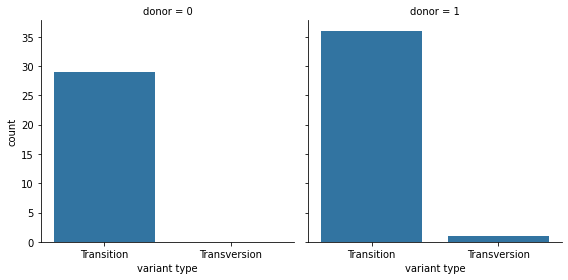

In [14]:
if len(donor_spec_vcf_df) > 1:
    g = sns.FacetGrid(data=donor_spec_vcf_df, col="donor", height=4)
    g.map_dataframe(sns.countplot, x="variant type")
    g.fig.savefig(join(outdir, "variant_type_donor_vars.pdf"), bbox_inches='tight', pad_inches=0.5)
# elif len(donor_spec_vcf_df) == 1:   
#     f = plt.figure()
#     sns.heatmap(donor_spec_vcf_df)
#     plt.savefig(join(outdir, "variant_type_donor_vars.pdf"), bbox_inches='tight', pad_inches=0.5)
    

In [15]:
all_vcf_df

,#CHROM,POS,REF,ALT,donor,ID,variant type,variant,is_donor_var
0,MT,4769,A,G,0,4769A>G,Transition,4769G,True
1,MT,11453,G,A,0,11453G>A,Transition,11453A,False
2,MT,14233,A,G,0,14233A>G,Transition,14233G,False
3,MT,709,G,A,0,709G>A,Transition,709A,False
4,MT,14905,G,A,0,14905G>A,Transition,14905A,False
...,...,...,...,...,...,...,...,...,...
130,MT,3847,T,C,1,3847T>C,Transition,3847C,False
131,MT,10397,A,G,1,10397A>G,Transition,10397G,False
132,MT,3244,G,A,1,3244G>A,Transition,3244A,False
133,MT,10559,A,G,1,10559A>G,Transition,10559G,True


In [16]:
# g = sns.FacetGrid(data=all_vcf_df, col="donor")
# g.map_dataframe(sns.countplot, x="variant type")
# g

In [17]:
all_vcf_df.groupby(["donor", "variant type"]).size()

donor  variant type
0      Transition      67
       Transversion     1
1      Transition      66
       Transversion     1
dtype: int64

# B. Violinplot across conditions and donors of donor vars (colored by transition/transversion)

In [18]:
long_all_af = pd.merge(all_af, cells_meta.set_index("ID")[["condition", "donor"]], left_index=True, right_index=True).reset_index().melt(id_vars=["index", "condition", "donor"], var_name="Variant", value_name="AF")
long_all_af

long_all_af["variant type"] = long_all_af["Variant"].apply(lambda x: variant_df.loc[x, "variant type"])
long_all_af


,index,condition,donor,Variant,AF,variant type
0,AAACGAACAAGCGAAC-1_Flt3l,Flt3l,0,4769G,1.000000,Transition
1,AAACGAACACAGCCAC-1_Flt3l,Flt3l,0,4769G,1.000000,Transition
2,AAACGAACACAGGTAG-1_Flt3l,Flt3l,0,4769G,0.000000,Transition
3,AAACGAACATAGAATG-1_Flt3l,Flt3l,0,4769G,1.000000,Transition
4,AAACGAAGTATTCGAC-1_Flt3l,Flt3l,0,4769G,1.000000,Transition
...,...,...,...,...,...,...
926584,TTTGTGTCAATGACTC-1_Input,Input,1,4166G,0.000000,Transition
926585,TTTGTGTCAGAAAGAG-1_Input,Input,1,4166G,0.000000,Transition
926586,TTTGTGTCATAGCCAT-1_Input,Input,1,4166G,0.000000,Transition
926587,TTTGTGTGTCATAGAA-1_Input,Input,1,4166G,0.023529,Transition


In [19]:
# g = sns.FacetGrid(data=long_all_af, col="donor", height=4)
# g.map_dataframe(sns.pointplot, y="AF", x="condition", hue="variant type", hue_order=["Transition", "Transversion"])
# plt.legend()
# g.fig.savefig(join(outdir, "variant_type_all_vars.pdf"), bbox_inches='tight', pad_inches=0.5)

# C. Transition vs transversion AF overall per donor

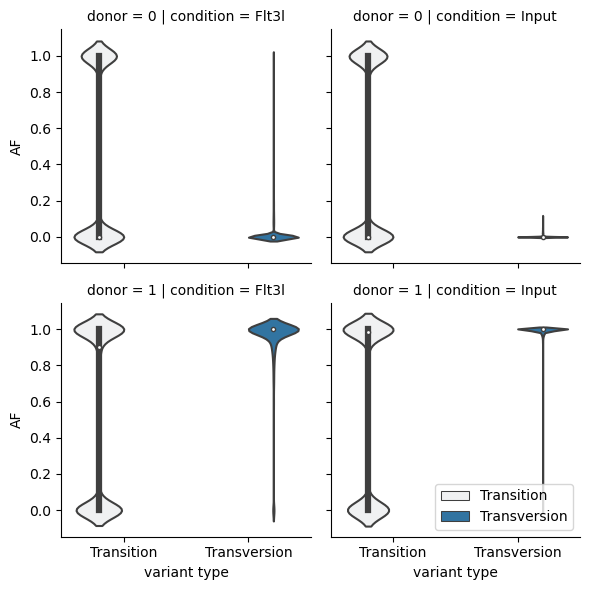

In [20]:
g = sns.FacetGrid(data=long_all_af, row="donor", col="condition", 
                  )
g.map_dataframe(sns.violinplot, y="AF", x= "variant type", hue="variant type", hue_order=["Transition", "Transversion"])
g.fig.savefig(join(outdir, "variant_af_all_vars_violin.pdf"), bbox_inches='tight', pad_inches=0.5)
plt.legend()

In [21]:
don_vars = []
for x in all_donor_vars:
    don_vars.extend(all_donor_vars[x])
don_vars = set(don_vars)
don_vars

{'10397G',
 '10463C',
 '10559G',
 '10589A',
 '11251G',
 '11719A',
 '11761T',
 '11812G',
 '13188T',
 '13368A',
 '14233G',
 '1438G',
 '146C',
 '14766T',
 '14905A',
 '150T',
 '15326G',
 '15452A',
 '15607G',
 '15928A',
 '16126C',
 '16294T',
 '16296T',
 '16304C',
 '16355T',
 '16362C',
 '16519C',
 '1888A',
 '196C',
 '204C',
 '2442C',
 '263G',
 '2706G',
 '310C',
 '3847C',
 '4117C',
 '4216C',
 '4769G',
 '4917G',
 '5147A',
 '5580C',
 '58C',
 '64T',
 '7028T',
 '709A',
 '73G',
 '750G',
 '7598A',
 '827G',
 '8292A',
 '8461T',
 '8697A',
 '8860G',
 '930A'}

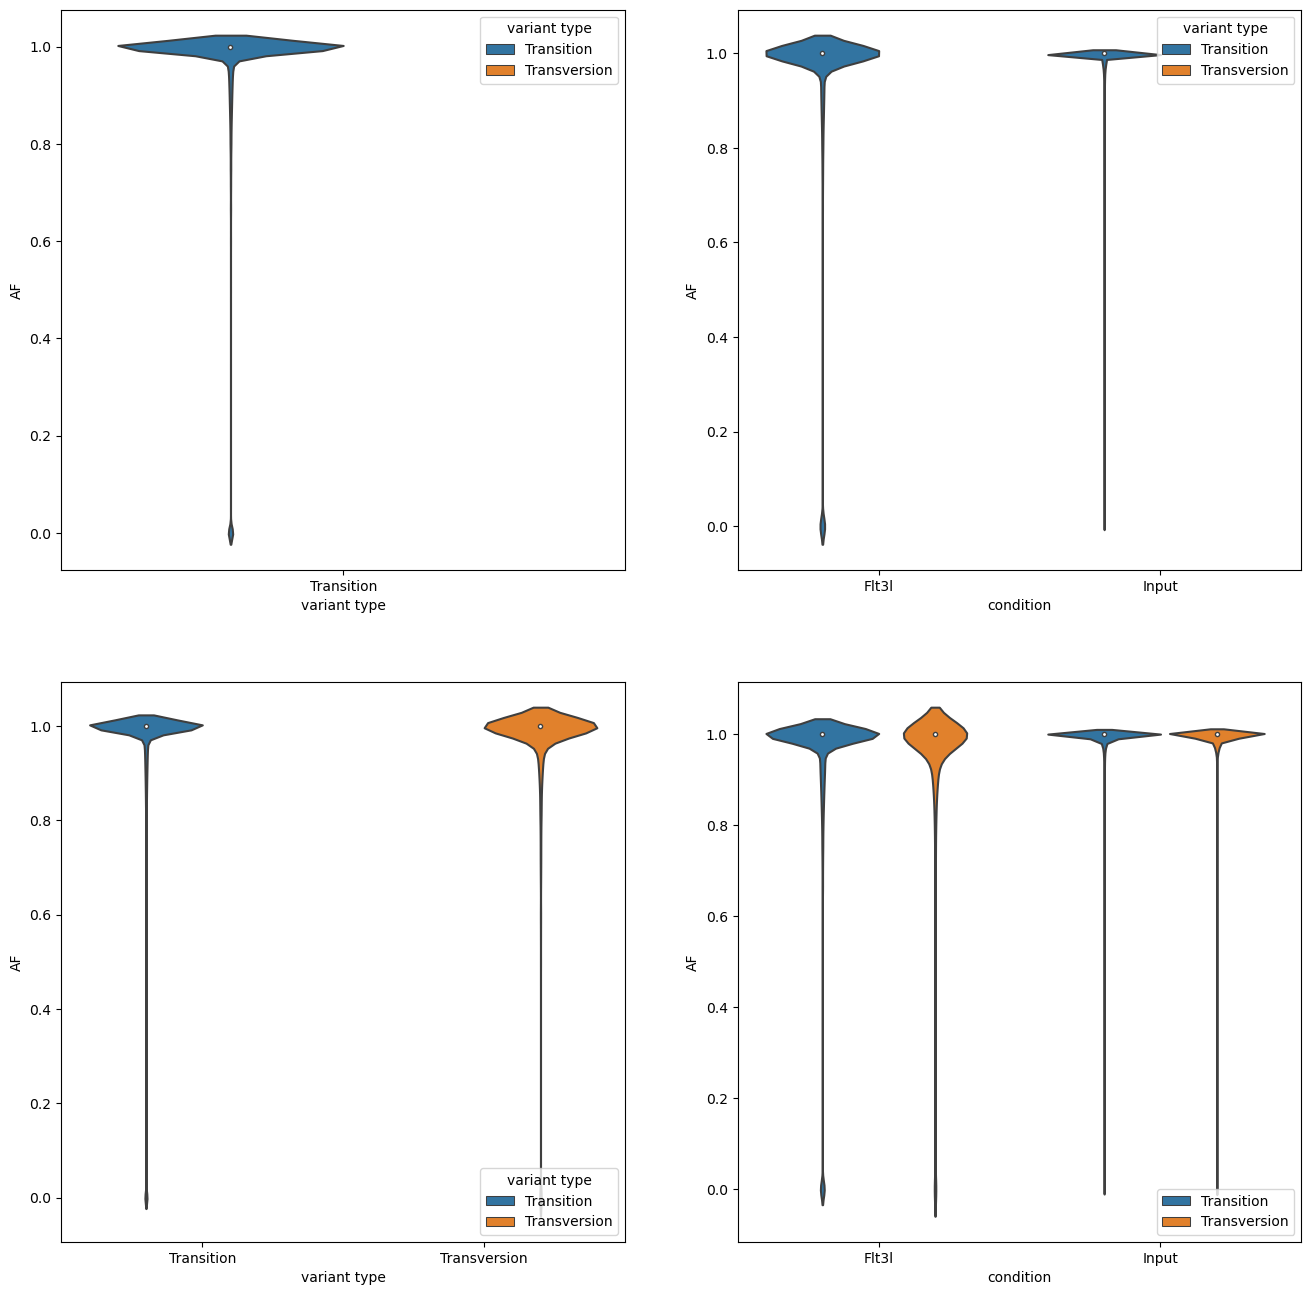

In [22]:
if len(don_vars) > 0:
    long_don_af = pd.merge(all_af.loc[:,all_af.columns.isin(don_vars)], cells_meta.set_index("ID")[["condition", "donor"]], left_index=True, right_index=True).reset_index().melt(id_vars=["index", "condition", "donor"], var_name="Variant", value_name="AF")
    long_don_af
    long_don_af = long_don_af[long_don_af["Variant"].isin(don_vars)]
    long_don_af["variant type"] = long_don_af["Variant"].apply(lambda x: variant_df.loc[x, "variant type"])
    long_don_af


    f, ax = plt.subplots(figsize=(16,16), nrows=len(all_donor_vars),ncols=2, sharex=False, sharey=False)#squeeze=True)
    for d, val in long_don_af.groupby("donor"):
        val = val[val["Variant"].isin(all_donor_vars[d])]
        #g = sns.FacetGrid(data=long_don_af, row="donor", col="condition")
        #g.map_dataframe(sns.violinplot, y="AF", x= "variant type", hue="variant type", hue_order=["Transition", "Transversion"])

        sns.violinplot(data=val, y="AF", x= "variant type", hue="variant type", hue_order=["Transition", "Transversion"], ax=ax[d,0])
        sns.violinplot(data=val, y="AF", x= "condition", hue="variant type", hue_order=["Transition", "Transversion"], ax=ax[d,1])
    plt.legend()
    plt.savefig(join(outdir, "variant_af_donor_vars_violin.pdf"), bbox_inches='tight', pad_inches=0.5)